# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, `TfmOver`, and `Transform`

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [ ]:
from PIL.ImageFile import ImageFile

In [ ]:
#torch.cuda.set_device(6)

## Overview

- start with list of filenames
- end with iterator of tensor batches
- display a batch
- display a prediction
  - a prediction should be same structure as a batch (?)
- filename -> (image,label)
- image:
  - open
  - make tensor
  - augment (at PIL, image tensor, or batch tensor level)
    - don't apply to valid set; toggle on/off as needed (e.g. fix_dl)
    - same rand for x/y
    - segment needs nearest neighbor, bbox/points need different funcs
  - show: dataset-wide params like cmap and alpha; denorm params; to_cpu
- label:
  - view text (needs state: vocab)
  - get number
- batch:
  - concat tuples
  - normalize
  - CUDA / float tensor
  - augment

## v1

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]
img = PIL.Image.open(fn); img

In [ ]:
def mk_tensor(im): return tensor(array(im))[None]

In [ ]:
imgt = mk_tensor(img)
imgt.shape,type(imgt)

(torch.Size([1, 28, 28]), torch.Tensor)

In [ ]:
lbls = items.mapped(parent_label)
itos,stoi = uniqueify(lbls, bidir=True, sort=True)
lbls[0], stoi['3']

('3', 0)

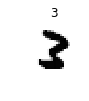

In [ ]:
show_image(imgt, title=lbls[0], figsize=(1,1), cmap="Greys");

In [ ]:
@patch
def dihedral(im:ImageFile, idx=0): return im.transpose(idx-1) if idx>=1 else im
def rand_dihedral(im): return im.dihedral(random.randint(0,7))

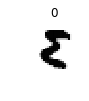

In [ ]:
pipe_open = compose(PIL.Image.open, rand_dihedral, mk_tensor)

class MNIST():
    def __getitem__(self,i): return pipe_open(items[i]), stoi[lbls[i]]
    def __len__(self): return len(items)

ds = MNIST()
show_titled_image(ds[0], figsize=(1,1), cmap="Greys")

In [ ]:
dl = DataLoader(ds, batch_size=9)
b = next(iter(dl))
x,y = to_device(b)
x = x.float()/255.

In [ ]:
def normalize  (o,m,s): return (o-m)/s
def denormalize(o,m,s): return (o*s)+m

def decode_vocab(o, v): return [v[o_] for o_ in o]

In [ ]:
m,s = 0.1,0.3
x = normalize(x,m,s)
x.mean(),x.std()

(tensor(0.0727, device='cuda:0'), tensor(0.9880, device='cuda:0'))

In [ ]:
denorm = partial(denormalize,m=m,s=s)
decode = partial(decode_vocab, v=itos)

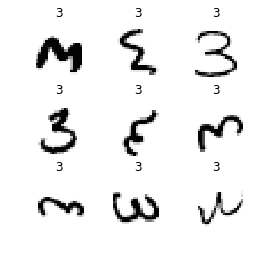

In [ ]:
show_image_batch((denorm(x),decode(y)), cmap="Greys", figsize=(4,4))

## v2

In [ ]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [ ]:
def floatify(o): return o.float()/255.

In [ ]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = getattr(next(iter(sig.parameters.items())), 'annotation', None)
    return (t_in,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

In [ ]:
class Transform(metaclass=PrePostInitMeta):
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
    
    def __post_init__(self):
        self.type_in,self.type_out = _get_types(self.encodes)
        if hasattr(self, 'decodes'):
            t_out,t_in = _get_types(self.decodes)
            self.type_in  = _check_same(self.type_in,  t_in)
            self.type_out = _check_same(self.type_out, t_out)

    def __call__(self, m, t=None): 
        return (self.encodes(m), t if self.type_out is None else self.type_out)
    def decode(self, m, t=None):   
        return (getattr(self, 'decodes', noop)(m), t if self.type_in is None else self.type_in)

In [ ]:
class Normalize(Transform):
    def __init__(self, m, s): self.m,self.s = m,s
    def encodes(self,o): return (o-self.m)/self.s 
    def decodes(self,o): return (o*self.s)+self.m 

norm_mnist = Normalize(m,s)

In [ ]:
imgt = floatify(imgt)
imgt.mean(),imgt.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
imgn = norm_mnist(imgt)[0]
imgn.mean(),imgn.std()

(tensor(0.3277), tensor(1.2535))

In [ ]:
imgt2 = norm_mnist.decode(imgn)[0]
imgt2.mean(),imgt2.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [ ]:
String.show("3")

3


In [ ]:
class Categorify(Transform):
    def __init__(self, vocab): self.vocab = vocab
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [ ]:
tst = Categorify(vocab)

In [ ]:
tst.type_out,tst.type_in

(None, __main__.String)

In [ ]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [ ]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [ ]:
def compose_tfms(x, t, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x,t = getattr(tfm,func_nm,noop)(x, t)
    return x,t

class Pipeline():
    def __init__(self, *tfms): self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
    def __call__(self, o, t=None): return compose_tfms(o, t, self.tfms)
    def decode  (self, i, t=None): return compose_tfms(i, t, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, t=None, ctx=None, **kwargs):
        for tfm in reversed(self.tfms):
            if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)
            o,t = tfm.decode(o,t)
        if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)

In [ ]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(Categorify(vocab))

In [ ]:
class MNIST(): #Missing xy transforms
    def __init__(self, items, lbls, f_x, f_y): #, t_x=None,t_y=None):
        self.items,self.lbls,self.f_x,self.f_y = items,lbls,f_x,f_y
        self.t_x,self.t_y = None,None
#         self.t_x,self.t_y = t_x,t_y
        
    def __getitem__(self, i): 
        x,self.final_t_x = self.f_x(self.items[i], self.t_x)
        y,self.final_t_y = self.f_y(self.lbls[i],  self.t_y)
        return x,y
    
    def __len__(self): return len(items)
    def show_at(self, i, ctx=None, **kwargs):
        x,y = self[i]
        ctx =  self.f_x.show(x, t=self.final_t_x, ctx=ctx, **kwargs)
        return self.f_y.show(y, t=self.final_t_y, ctx=ctx, **kwargs)

ds = MNIST(items, lbls, pipe_x, pipe_y)

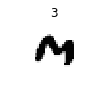

In [ ]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [ ]:
dl = DataLoader(ds, batch_size=9)

In [ ]:
class MNIST_DL():
    def __init__(self, dl, f_x, f_y): self.dl,self.f_x,self.f_y = dl,f_x,f_y
    def __iter__(self): 
        for x,y in self.dl:
            t_x = getattr(self.dl.dataset, 'final_t_x', None)
            t_y = getattr(self.dl.dataset, 'final_t_y', None)
            x1,self.final_t_x = self.f_x(x, t_x)
            y1,self.final_t_y = self.f_y(y, t_y)
            yield x1,y1
    def __len__(self): return len(self.dl)
    
    def decode_batch(self, b):
        x,y = b
        (x,t_x) = self.f_x.decode(x, self.final_t_x)
        (y,t_y) = self.f_y.decode(y, self.final_t_y)
        return (x,y),(t_x,t_y)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b,ts = self.decode_batch(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs):
            ctx = self.dl.dataset.f_x.show(o[0], t=ts[0], ctx=ctx, **kwargs)
            self.dl.dataset.f_y.show(o[1], t=ts[1], ctx=ctx, **kwargs)

dl_pipe_x = Pipeline(to_device, floatify, norm_mnist)
dl_pipe_y = Pipeline(to_device)
mdl = MNIST_DL(dl, dl_pipe_x, dl_pipe_y)

In [ ]:
b = next(iter(mdl))

In [ ]:
b[0].shape,b[1].shape

(torch.Size([9, 1, 28, 28]), torch.Size([9]))

In [ ]:
mdl.final_t_x,mdl.final_t_y

(__main__.TensorImage, None)

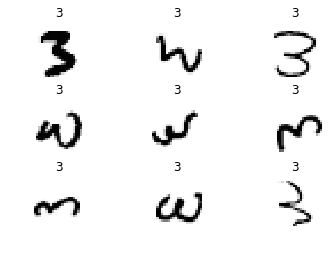

In [ ]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)

## v3

In [ ]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [ ]:
def floatify(o): return o.float()/255.

In [ ]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = [p.annotation if p.annotation != inspect._empty else None 
            for p in sig.parameters.values() if p.default == inspect._empty]
    if len(t_in) == 1: t_in = t_in[0]
    return (t_in,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

In [ ]:
class Transform(metaclass=PrePostInitMeta):
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
    
    def __post_init__(self):
        self.type_in,self.type_out = _get_types(self.encodes) if hasattr(self, 'encodes') else (None,None)
        if hasattr(self, 'decodes'):
            t_out,t_in = _get_types(self.decodes)
            self.type_in  = _check_same(self.type_in,  t_in)
            self.type_out = _check_same(self.type_out, t_out)
    
    def __call__(self, o, t=None): 
        t = t if self.type_out is None else self.type_out
        if is_listy(t) and not is_listy(self.type_in):
            return (tuple(self.encode_with_type(o_, t=t_) for o_,t_ in zip(o,t)),t)
        return (self.encode_with_type(*L(o), t),t)
                
    def decode(self, o, t=None):    # XXX: refactor
        t = t if self.type_in is None else self.type_in
        if is_listy(t) and not is_listy(self.type_out):
            return (tuple(self.decode_with_type(o_, t=t_) for o_,t_ in zip(o,t)),t)
        return (self.decode_with_type(*L(o), t),t)
    
    def encode_with_type(self, m, t=None): return self.encodes(m)
    def decode_with_type(self, m, t=None): return getattr(self, 'decodes', noop)(m)

In [ ]:
@patch
def   normalize(self:TensorImage, m, s): return (self-m)/s
@patch
def denormalize(self:TensorImage, m, s): return (self*s)+m

In [ ]:
class Normalize(Transform):
    def __init__(self, m, s): self.m,self.s = m,s
    def encode_with_type(self,o,t): return getattr(t,  'normalize',noop)(o, self.m, self.s)
    def decode_with_type(self,o,t): return getattr(t,'denormalize',noop)(o, self.m, self.s)

norm_mnist = Normalize(m,s)

In [ ]:
imgt.mean(),imgt.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
imgn = norm_mnist(imgt, TensorImage)[0]
imgn.mean(),imgn.std()

(tensor(0.3277), tensor(1.2535))

In [ ]:
imgt2 = norm_mnist.decode(imgn, TensorImage)[0]
imgt2.mean(),imgt2.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [ ]:
String.show("3")

3


In [ ]:
class Categorify(Transform):
    def __init__(self, vocab): self.vocab = vocab
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [ ]:
tst = Categorify(vocab)

In [ ]:
tst.type_out,tst.type_in

(None, __main__.String)

In [ ]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [ ]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [ ]:
def compose_tfms(x, t, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x,t = getattr(tfm,func_nm,noop)(x, t)
    return x,t

class Pipeline(PrePostInit):
    def __init__(self, *tfms): self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
    def __call__(self, o, t=None): return compose_tfms(o, t, self.tfms)
    def decode  (self, i, t=None): return compose_tfms(i, t, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, t=None, ctx=None, **kwargs):
        for tfm in reversed(self.tfms):
            if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)
            o,t = tfm.decode(o,t)
        if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)

In [ ]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(Categorify(vocab))

In [ ]:
class MNIST(): #Missing xy transforms
    def __init__(self, items, lbls, f_x, f_y, f_xy): #, t_x=None,t_y=None):
        self.items,self.lbls,self.f_x,self.f_y,self.f_xy = items,lbls,f_x,f_y,f_xy
        self.t_x,self.t_y = None,None
#         self.t_x,self.t_y = t_x,t_y
        
    def __getitem__(self, i): 
        x,t_x = self.f_x(self.items[i], self.t_x)
        y,t_y = self.f_y(self.lbls[i],  self.t_y)
        (x,y),self.final_t = self.f_xy((x,y), [t_x,t_y])
        return x,y
    
    def __len__(self): return len(items)
    def show_at(self, i, ctx=None, **kwargs):
        x,y = self[i]
        (x,y),(t_x,t_y) = self.f_xy.decode((x,y), self.final_t)
        ctx =  self.f_x.show(x, t=t_x, ctx=ctx, **kwargs)
        return self.f_y.show(y, t=t_y, ctx=ctx, **kwargs)

In [ ]:
ds = MNIST(items, lbls, pipe_x, pipe_y, Pipeline())

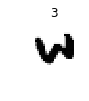

In [ ]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [ ]:
dl = DataLoader(ds, batch_size=9)

In [ ]:
@patch
def floatify(x:TensorImage): return x.float()/255. 

class Floatify(Transform):
    def encode_with_type(self, x, t): return getattr(t, 'floatify', noop)(x)

In [ ]:
dl_pipe = Pipeline(to_device, Floatify(), norm_mnist)

In [ ]:
class MNIST_DL():
    def __init__(self, dl, f): self.dl,self.f = dl,f
    def __iter__(self): 
        for b in self.dl:
            t = getattr(self.dl.dataset, 'final_t', None)
            b,self.final_t = self.f(b,t)
            yield b
    def __len__(self): return len(self.dl)
    
    def decode_batch(self, b):
        return self.f.decode(b, self.final_t)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b,ts = self.decode_batch(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs):
            (x,y),(t_x,t_y) = self.dl.dataset.f_xy.decode(o, ts)
            ctx = self.dl.dataset.f_x.show(x, t=t_x, ctx=ctx, **kwargs)
            self.dl.dataset.f_y.show(y, t=t_y, ctx=ctx, **kwargs)

In [ ]:
mdl = MNIST_DL(dl, dl_pipe)

In [ ]:
b = next(iter(mdl))

In [ ]:
b[0].shape,b[1].shape

(torch.Size([9, 1, 28, 28]), torch.Size([9]))

In [ ]:
mdl.final_t

[__main__.TensorImage, None]

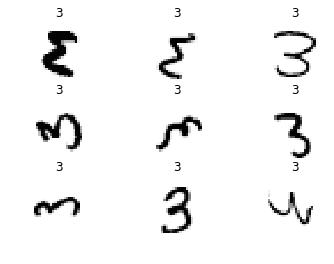

In [ ]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)

## v4

In [ ]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [ ]:
def floatify(o): return o.float()/255.

In [ ]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = [p.annotation if p.annotation != inspect._empty else None 
            for p in sig.parameters.values() if p.default == inspect._empty]
    return (len(t_in) > 1,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

In [ ]:
class Transform(metaclass=PrePostInitMeta):
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
    
    def __post_init__(self):
        self.is_tuple_in, t1 = _get_types(self.encodes) if hasattr(self, 'encodes') else (False,None)
        self.is_tuple_out,t2 = _get_types(self.decodes) if hasattr(self, 'decodes') else (False,None)
        self.type = _check_same(t1, t2)
    
    def __call__(self, o): 
        if is_listy(o) and not self.is_tuple_in:
            return tuple(self.encode_with_type(o_, t=t_) for o_,t_ in zip(o,self.type))
        return self.encode_with_type(*L(o), self.type)
                
    def decode(self, o):    # XXX: refactor
        if is_listy(o) and not self.is_tuple_out:
            return tuple(self.decode_with_type(o_, t=t_) for o_,t_ in zip(o,self.type))
        return self.decode_with_type(*L(o), self.type)
    
    def encode_with_type(self, m, t=None): return self.encodes(m)
    def decode_with_type(self, m, t=None): return getattr(self, 'decodes', noop)(m)

In [ ]:
@patch
def   normalize(self:TensorImage, m, s): return (self-m)/s
@patch
def denormalize(self:TensorImage, m, s): return (self*s)+m

In [ ]:
class Normalize(Transform):
    def __init__(self, m, s): self.m,self.s = m,s
    def encode_with_type(self,o,t): return getattr(t,  'normalize',noop)(o, self.m, self.s)
    def decode_with_type(self,o,t): return getattr(t,'denormalize',noop)(o, self.m, self.s)

norm_mnist = Normalize(m,s)

In [ ]:
imgt.mean(),imgt.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
norm_mnist.type = TensorImage #Pipeline will set this
imgn = norm_mnist(imgt)
imgn.mean(),imgn.std()

(tensor(0.3277), tensor(1.2535))

In [ ]:
imgt2 = norm_mnist.decode(imgn)
imgt2.mean(),imgt2.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [ ]:
String.show("3")

3


In [ ]:
class Categorify(Transform):
    def __init__(self, vocab): self.vocab = vocab
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [ ]:
tst = Categorify(vocab)

In [ ]:
tst.type

__main__.String

In [ ]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [ ]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [ ]:
def compose_tfms(x, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x = getattr(tfm,func_nm,noop)(x)
    return x

class Pipeline():
    def __init__(self, *tfms): 
        self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
        
    def setup(self, t=None):
        if len(self.tfms) == 0: self.final_t = t
        else:
            if self.tfms[0].type is None: self.tfms[0].type = t
            for t_prec,t in zip(self.tfms[:-1],self.tfms[1:]):
                if t.type is None: t.type = t_prec.type
            self.final_t = self.tfms[-1].type
                
    def __call__(self, o): return compose_tfms(o, self.tfms)
    def decode  (self, i): return compose_tfms(i, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, ctx=None, **kwargs):
        r_tfms = list(reversed(self.tfms))
        for i,tfm in enumerate(r_tfms):
            o = tfm.decode(o)
            if hasattr(tfm.type, 'show') and (i==len(r_tfms)-1 or r_tfms[i+1].type!=tfm.type):
                #tfm.type knows how to show AND is the first tfm with this type
                return tfm.type.show(o, ctx=ctx, **kwargs)

In [ ]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(Categorify(vocab))

In [ ]:
class MNIST():
    def __init__(self, items, lbls, f_x, f_y, f_xy):
        self.items,self.lbls,self.f_x,self.f_y,self.f_xy = items,lbls,f_x,f_y,f_xy
        #setup
        self.f_x.setup(); self.f_y.setup()
        self.f_xy.setup(t = [self.f_x.final_t, self.f_y.final_t])
        
    def __getitem__(self, i): 
        return self.f_xy([self.f_x(self.items[i]),self.f_y(self.lbls[i])])
    
    def __len__(self): return len(items)
    def show_at(self, i, ctx=None, **kwargs):
        x,y = self.f_xy.decode(self[i])
        ctx =  self.f_x.show(x, ctx=ctx, **kwargs)
        return self.f_y.show(y, ctx=ctx, **kwargs)

In [ ]:
ds = MNIST(items, lbls, pipe_x, pipe_y, Pipeline())

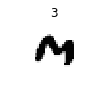

In [ ]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [ ]:
ds.f_xy.final_t

[__main__.TensorImage, __main__.String]

In [ ]:
dl = DataLoader(ds, batch_size=9)

In [ ]:
@patch
def floatify(x:TensorImage): return x.float()/255. 

class Floatify(Transform):
    def encode_with_type(self, x, t): return getattr(t, 'floatify', noop)(x)

In [ ]:
norm_mnist = Normalize(m,s)
dl_pipe = Pipeline(to_device, Floatify(), norm_mnist)

In [ ]:
class MNIST_DL():
    def __init__(self, dl, f): 
        self.dl,self.f = dl,f
        #setup
        t = getattr(self.dl.dataset.f_xy, 'final_t', None) if hasattr(self.dl.dataset, 'f_xy') else None
        self.f.setup(t=t)
        
    def __iter__(self): return (self.f(b) for b in self.dl)
    def __len__(self): return len(self.dl)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b = self.f.decode(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs):
            (x,y) = self.dl.dataset.f_xy.decode(o)
            ctx = self.dl.dataset.f_x.show(x, ctx=ctx, **kwargs)
            self.dl.dataset.f_y.show(y, ctx=ctx, **kwargs)

In [ ]:
mdl = MNIST_DL(dl, dl_pipe)

In [ ]:
b = next(iter(mdl))

In [ ]:
b[0].shape,b[1].shape

(torch.Size([9, 1, 28, 28]), torch.Size([9]))

In [ ]:
mdl.f.final_t

[__main__.TensorImage, __main__.String]

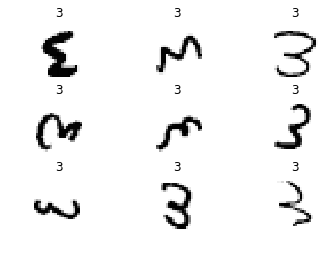

In [ ]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)

## v5

In [ ]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [ ]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = [p.annotation if p.annotation != inspect._empty else None 
            for p in sig.parameters.values() if p.default == inspect._empty and p.kind != inspect._VAR_KEYWORD]
#     if not t_out: t_out = t_in[0]
    return (len(t_in) > 1,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

In [ ]:
class Transform(metaclass=PrePostInitMeta):
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
    
    def __post_init__(self):
        is_tuple_in, t1 = _get_types(self.encodes) if hasattr(self, 'encodes') else (False,None)
        is_tuple_out,t2 = _get_types(self.decodes) if hasattr(self, 'decodes') else (False,None)
        assert is_tuple_in == is_tuple_out
        self.type = _check_same(t1, t2)
        self.is_tuple = is_tuple_in
        
    def __getattr__(self,k):
        if k not in ['encodes', 'decodes', 'decode']:
            def _inner(x, *args, **kwargs):
                return getattr(self.type,  k, noop)(x, *args, **kwargs)
            return _inner
        else: raise AttributeError
    
    def _apply(self, n, o):
        if is_listy(self.type) and not self.is_tuple:
            old_type = self.type
            res = []
            for o_,t in zip(o,old_type):
                self.type=t
                res.append(getattr(self, n, noop)(o_))
            self.type = old_type
            return tuple(res)
        return getattr(self, n, noop)(*L(o))
    
    def __call__(self, o): return self._apply('encodes', o)            
    def decode(self, o):   return self._apply('decodes', o)

In [ ]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [ ]:
String.show("3")

3


In [ ]:
class Categorify(Transform):
    def __init__(self, vocab): self.vocab = vocab
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [ ]:
tst = Categorify(vocab)
tst.type

__main__.String

In [ ]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [ ]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [ ]:
def compose_tfms(x, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x = getattr(tfm,func_nm,noop)(x)
    return x

In [ ]:
class Pipeline():
    def __init__(self, *tfms): 
        self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
        
    def setup(self, t=None):
        if len(self.tfms) == 0: self.final_t = t
        else:
            if self.tfms[0].type is None: self.tfms[0].type = t
            for t_prec,t in zip(self.tfms[:-1],self.tfms[1:]):
                if t.type is None: t.type = t_prec.type
            self.final_t = self.tfms[-1].type
                
    def __call__(self, o): return compose_tfms(o, self.tfms)
    def decode  (self, i): return compose_tfms(i, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, ctx=None, **kwargs):
        r_tfms = list(reversed(self.tfms))
        for i,tfm in enumerate(r_tfms):
            o = tfm.decode(o)
            if hasattr(tfm.type, 'show') and (i==len(r_tfms)-1 or r_tfms[i+1].type!=tfm.type):
                #tfm.type knows how to show AND is the first tfm with this type
                return tfm.type.show(o, ctx=ctx, **kwargs)

In [ ]:
class MNIST():
    def __init__(self, items, pipes, tuple_pipe):
        self.items,self.pipes,self.tuple_pipe = items,pipes,tuple_pipe
        for p in self.pipes: p.setup()
        self.tuple_pipe.setup(t = [p.final_t for p in self.pipes])
        
    def __getitem__(self, i): return self.tuple_pipe([p(self.items[i]) for p in self.pipes])
    def __len__(self): return len(items)
    
    def show(self, o, ctx=None, **kwargs):
        o = self.tuple_pipe.decode(o)
        for o_,p in zip(o,self.pipes): ctx = p.show(o_, ctx=ctx, **kwargs)
        return ctx
        
    def show_at(self, i, ctx=None, **kwargs): return self.show(self[i], ctx=ctx, **kwargs)

In [ ]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(parent_label, Categorify(vocab))

In [ ]:
ds = MNIST(items, [pipe_x, pipe_y], Pipeline())

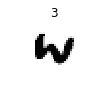

In [ ]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [ ]:
ds.tuple_pipe.final_t

[__main__.TensorImage, __main__.String]

In [ ]:
dl = DataLoader(ds, batch_size=9)

In [ ]:
@patch
def floatify(x:TensorImage): return x.float()/255.

In [ ]:
class Normalize(Transform):
    def __init__(self, m, s): self.m,self.s = m,s
    def encodes(self, o)->TensorImage: return (o-self.m)/self.s
    def decodes(self, o):              return (o*self.s)+self.m

norm_mnist = Normalize(m,s)

In [ ]:
imgf = floatify(imgt)

In [ ]:
imgf.mean(),imgf.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
imgn = norm_mnist(imgf)
imgn.mean(),imgn.std()

(tensor(0.3277), tensor(1.2535))

In [ ]:
imgf2 = norm_mnist.decode(imgn)
imgf2.mean(),imgf2.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
norm_mnist = Normalize(m,s)
dl_pipe = Pipeline(to_device, floatify, norm_mnist)

In [ ]:
class MNIST_DL():
    def __init__(self, dl, f): 
        self.dl,self.f = dl,f
        t = getattr(self.dl.dataset.tuple_pipe, 'final_t', None) if hasattr(self.dl.dataset, 'tuple_pipe') else None
        self.f.setup(t=t)
        
    def __iter__(self): return (self.f(b) for b in self.dl)
    def __len__(self): return len(self.dl)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b = self.f.decode(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs): self.dl.dataset.show(o, ctx=ctx, **kwargs)

In [ ]:
mdl = MNIST_DL(dl, dl_pipe)

In [ ]:
b = next(iter(mdl))

TypeError: encodes() takes 2 positional arguments but 3 were given

In [ ]:
b[0].shape,b[1].shape, b[0].mean(), b[0].std()
assert b[0].min()<0

In [ ]:
mdl.f.final_t

In [ ]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)

## v6

In [ ]:
class Transform(PrePostInit):
    def __init__(self,encode=None,decode=None):
        if encode: self.encode = encode
        if decode: self.decode = decode

In [ ]:
@patch
def powx(x:math, a): return math.pow(x,a)

@patch
def powx(x:torch, a): return torch.pow(x,a)

class Add1(Transform):
    def encode(self,x): return x+1
    def decode(self,x): return x-1

In [ ]:
def mk_torch(x)->torch: return tensor(x)
def mk_math (x)->math : return x

In [ ]:
class Func():
    def __init__(self, nm, *args, **kwargs): self.nm,self.args,self.kwargs = nm,args,kwargs
    def __call__(self,t):
        f = getattr(t,self.nm)
        if not (self.args or self.kwargs): return f
        return partial(f, *self.args, **self.kwargs)

In [ ]:
pipe_funcs = [(Func('powx',a=2), 'sqrt'), Add1()]

pf1 = [mk_math ] + pipe_funcs
pf2 = [mk_torch] + pipe_funcs

In [ ]:
def mk_func(f, t):
    if isinstance(f,str ): f = Func(f)
    if isinstance(f,Func): f = f(t)
    return f

def mk_tfm(f,t):
    if not is_listy(f): f = (f,None)
    return Transform(mk_func(f[0],t), mk_func(f[1],t))

In [ ]:
def compose_tfms(x, tfms, func_nm='encode', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x = getattr(tfm,func_nm,noop)(x)
    return x

In [ ]:
def _get_ret(func):
    ann = getattr(func,'__annotations__', None)
    if not ann: return None
    return ann.get('return')

In [ ]:
class Pipeline():
    def __init__(self, funcs):
        self.fs = []
        self.t = None
        for f in funcs:
            if not isinstance(f,Transform): f = mk_tfm(f, self.t)
            self.fs.append(f)
            self.t = _get_ret(f.encode) or self.t
                
    def __call__(self, o): return compose_tfms(o, self.fs)
    def decode  (self, i): return compose_tfms(i, self.fs, func_nm='decode', reverse=True)

In [ ]:
p1 = Pipeline(pf1)
a1 = p1(2); a1

5.0

In [ ]:
p1.decode(a1)

2.0

In [ ]:
p2 = Pipeline(pf2)
a2 = p2(tensor(2.)); a2

tensor(5.)

In [ ]:
p2.decode(a2)

tensor(2.)

## fin